<a href="https://colab.research.google.com/github/sultanmr/travel-tide/blob/main/TravelTide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime

# Data Loading and Initial Exploration

In [ ]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQG-wCbO5UkiHOfPbExP0OkKkLg8qJ2w2PGlbP1prp8TpndCfAuFqe8W7VO4JXhYVeuCcA-TxNvNdb/pub?gid=389458990&single=true&output=csv"
'''
The above URL does contain the following filtered data:

WITH session_counts AS (
    SELECT
        DISTINCT s.user_id
    FROM
        sessions s
    WHERE
        s.session_start > '2023-01-04'
    GROUP BY
        s.user_id
    HAVING
        COUNT(*) > 7
)

SELECT
  u.user_id,
  u.home_country,
  u.gender,
  s.session_id,
  s.session_start,
  s.session_end,
  f.trip_id,
  f.destination,
  h.trip_id,
  h.hotel_name
FROM
    session_counts sc
LEFT JOIN users u ON u.user_id = sc.user_id
LEFT JOIN sessions s ON s.user_id = sc.user_id
LEFT JOIN flights f ON s.trip_id = f.trip_id
LEFT JOIN hotels h ON s.trip_id = h.trip_id

WHERE
		h.nights>0 AND h.rooms>0
ORDER BY
    u.user_id, s.session_start;
LEFT JOIN hotels h ON s.trip_id = h.trip_id
'''

"\nThe above URL does contain the following filtered data:\n\nWITH session_counts AS (\n    SELECT\n        DISTINCT s.user_id\n    FROM\n        sessions s\n    WHERE\n        s.session_start > '2023-01-04'\n    GROUP BY\n        s.user_id\n    HAVING\n        COUNT(*) > 7\n)\n\nSELECT\n  u.user_id,\n  u.home_country,\n  u.gender,\n  s.session_id,\n  s.session_start,\n  s.session_end,\n  f.trip_id,\n  f.destination,\n  h.trip_id,\n  h.hotel_name\nFROM\n    session_counts sc\nLEFT JOIN users u ON u.user_id = sc.user_id\nLEFT JOIN sessions s ON s.user_id = sc.user_id\nLEFT JOIN flights f ON s.trip_id = f.trip_id\nLEFT JOIN hotels h ON s.trip_id = h.trip_id\n\nWHERE\n\t\th.nights>0 AND h.rooms>0\nORDER BY\n    u.user_id, s.session_start;\nLEFT JOIN hotels h ON s.trip_id = h.trip_id\n"

In [ ]:
data = pd.read_csv(url, index_col="user_id")

# Initial Data Exploration
print(data.head())
print(data.columns)
print(data.dtypes)
print(data['gender'].value_counts())
data = data[data['gender'] != 'O']
print(data.isnull().sum())
print(data["home_country"].value_counts())

          birthdate gender  married  has_children home_country    home_city  \
user_id                                                                       
23557    1958-12-08      F     True         False          usa     new york   
23557    1958-12-08      F     True         False          usa     new york   
23557    1958-12-08      F     True         False          usa     new york   
94883    1972-03-16      F     True         False          usa  kansas city   
101486   1972-12-07      F     True          True          usa       tacoma   

        home_airport  home_airport_lat  home_airport_lon sign_up_date  ...  \
user_id                                                                ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
23557            LGA            40.777           -73.872   2021-07-22  ...   
94883            MCI            39.297           -94.714

# Data Preprocessing

In [ ]:
data["married"] = data["married"].astype("int")
data["has_children"] = data["has_children"].astype("int")
data["gender"] = (data["gender"] == 'F').astype("int")
data["home_country"] = (data["home_country"] == 'canada').astype("int")

print(data.describe(include="all"))
print(data.dtypes)

         birthdate        gender       married  has_children  home_country  \
count        13978  13978.000000  13978.000000  13978.000000  13978.000000   
unique        4289           NaN           NaN           NaN           NaN   
top     1979-01-06           NaN           NaN           NaN           NaN   
freq            17           NaN           NaN           NaN           NaN   
mean           NaN      0.886035      0.441193      0.304335      0.176349   
std            NaN      0.317780      0.496547      0.460142      0.381130   
min            NaN      0.000000      0.000000      0.000000      0.000000   
25%            NaN      1.000000      0.000000      0.000000      0.000000   
50%            NaN      1.000000      0.000000      0.000000      0.000000   
75%            NaN      1.000000      1.000000      1.000000      0.000000   
max            NaN      1.000000      1.000000      1.000000      1.000000   

       home_city home_airport  home_airport_lat  home_airport_l

# Adding New Features

In [ ]:
data['birthdate']  = pd.to_datetime(data['birthdate'])
data['age'] = (datetime.now() - data['birthdate']).dt.days // 365

In [ ]:
# Aggregate user travel behavior (metrics related to valid trips)
def haversine_distance(lat1, lon1, lat2, lon2):
    # Haversine formula to calculate distance between two points on Earth
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

data['travel_distance_km'] = haversine_distance(data['home_airport_lat'], data['home_airport_lon'], data['destination_airport_lat'], data['destination_airport_lon'])
data['travel_distance_km'] = data['travel_distance_km'].fillna(data['travel_distance_km'].mean())

In [ ]:
# Flight and Hotel Booking Correlation (same session booking)
data['flight_hotel_booked'] = (data['flight_booked'] & data['hotel_booked']).astype(int)

In [ ]:
# Flight Duration (difference between departure and return times)
data['flight_duration_days'] = (pd.to_datetime(data['return_time']) - pd.to_datetime(data['departure_time'])).dt.days
flight_duration_days_mean = round(data['flight_duration_days'].mean())
data['flight_duration_days'] = data['flight_duration_days'].fillna(flight_duration_days_mean)

In [ ]:
# Hotel Stay Duration (difference between check-in and check-out)
data['hotel_stay_duration'] = (pd.to_datetime(data['check_out_time']) - pd.to_datetime(data['check_in_time'])).dt.days

In [ ]:
# Total Hotel Room Cost
data['total_hotel_cost'] = data['hotel_per_room_usd'] * data['rooms']

In [ ]:
# Active Days (days since user signed up)
data['active_days'] = (datetime.now() - pd.to_datetime(data['sign_up_date'])).dt.days

In [ ]:
# Cancellation Rate (proportion of cancelled flights)
user_cancellations = data.groupby('user_id')['cancellation'].mean().reset_index()
user_cancellations.columns = ['user_id', 'cancellation_rate']
data = pd.merge(data, user_cancellations, on='user_id', how='left')

# Feature Selection & Encoding

In [ ]:
features = [
    'gender', 'married', 'has_children', 'flight_booked',
    'page_clicks', 'cancellation', 'seats', 'checked_bags',
    'base_fare_usd', 'nights', 'rooms', 'hotel_per_room_usd',
    'travel_distance_km', 'age', 'flight_hotel_booked', 'flight_duration_days',
    'hotel_stay_duration', 'total_hotel_cost', 'active_days',
    'cancellation_rate'
]
#data_numeric = data[features].copy()
data_numeric = data[["user_id"] + features].copy()
data_numeric["gender"] = data_numeric["gender"].astype("category").cat.codes
data_numeric["married"] = data_numeric["married"].astype("category").cat.codes
data_numeric["has_children"] = data_numeric["has_children"].astype("category").cat.codes

# Fill missing values
data_numeric['base_fare_usd'] = data_numeric['base_fare_usd'].fillna(data_numeric['base_fare_usd'].mean())
data_numeric['seats'] = data_numeric['seats'].fillna(round(data_numeric['seats'].median()))
data_numeric['checked_bags'] = data_numeric['checked_bags'].fillna(round(data_numeric['checked_bags'].median()))


In [ ]:
data_numeric.isnull().sum()

,0
user_id,0
gender,0
married,0
has_children,0
flight_booked,0
page_clicks,0
cancellation,0
seats,0
checked_bags,0
base_fare_usd,0


# Data Scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numeric[features])

# Finding Optimal Number of Clusters (Elbow Method)

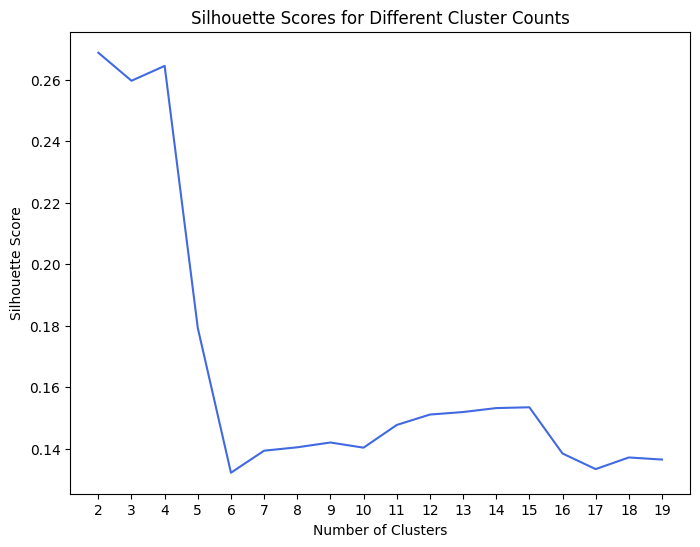

In [ ]:
scores = []
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    groups = kmeans.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, groups))

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(2, 20), y=scores, color='royalblue')
plt.xticks(range(2, 20))
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(False)
plt.show()

# KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
groups = kmeans.fit_predict(X_scaled)
data_numeric["cluster"] = groups
data["cluster"] = groups
print(data_numeric["cluster"].value_counts())

cluster
5    4980
2    3905
0    2468
1    1336
4     747
3     542
Name: count, dtype: int64


# PCA Visualization

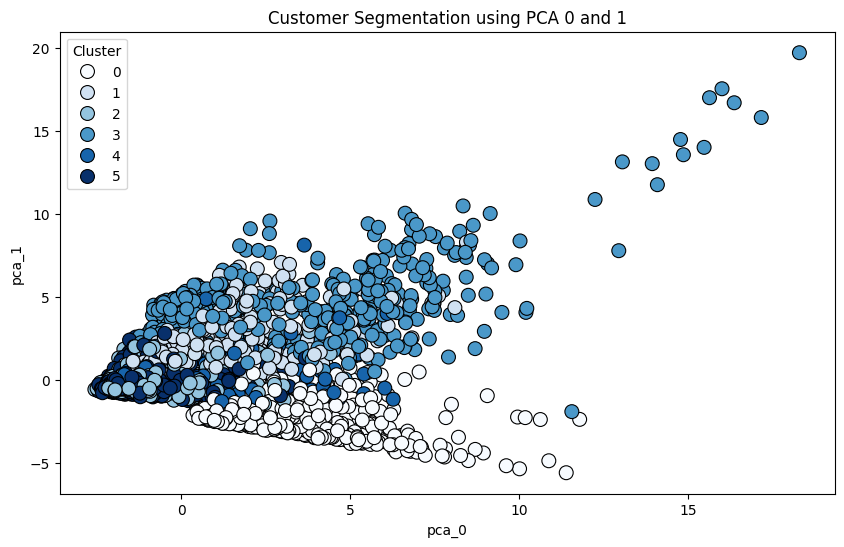

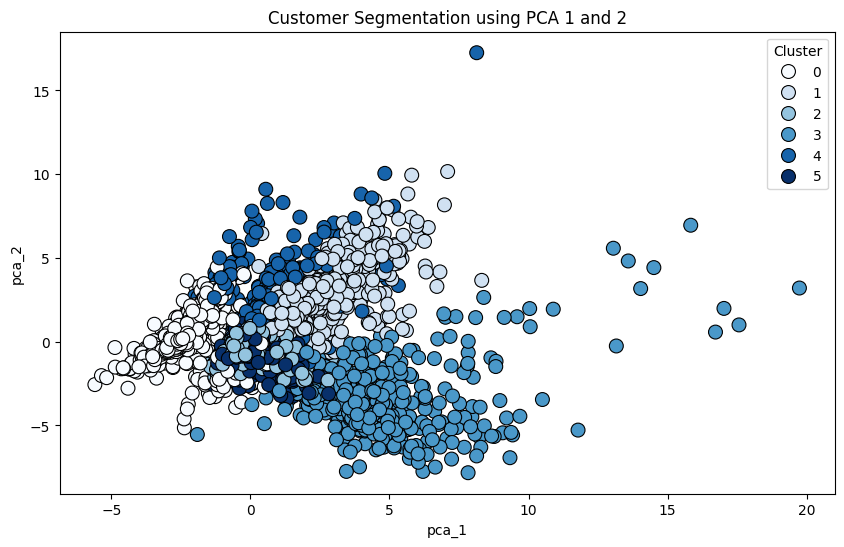

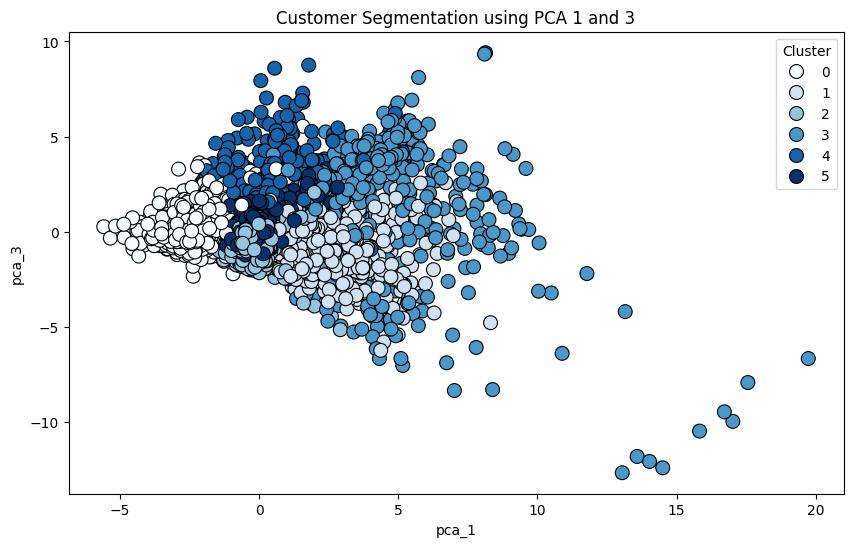

In [ ]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=["pca_0", "pca_1", "pca_2", "pca_3"])
groups = pd.Series(groups)
pca_viz = pd.concat([X_pca_df, groups.reset_index(drop=True)], axis=1)
pca_viz.columns = ["pca_0", "pca_1", "pca_2", "pca_3", "cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_viz, x="pca_0", y="pca_1", hue="cluster", palette="Blues", s=100, edgecolor='black')
plt.title("Customer Segmentation using PCA 0 and 1")
plt.legend(title="Cluster")
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_viz, x="pca_1", y="pca_2", hue="cluster", palette="Blues", s=100, edgecolor='black')
plt.title("Customer Segmentation using PCA 1 and 2")
plt.legend(title="Cluster")
plt.grid(False)
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_viz, x="pca_1", y="pca_3", hue="cluster", palette="Blues", s=100, edgecolor='black')
plt.title("Customer Segmentation using PCA 1 and 3")
plt.legend(title="Cluster")
plt.grid(False)
plt.show()

# Cluster Analysis

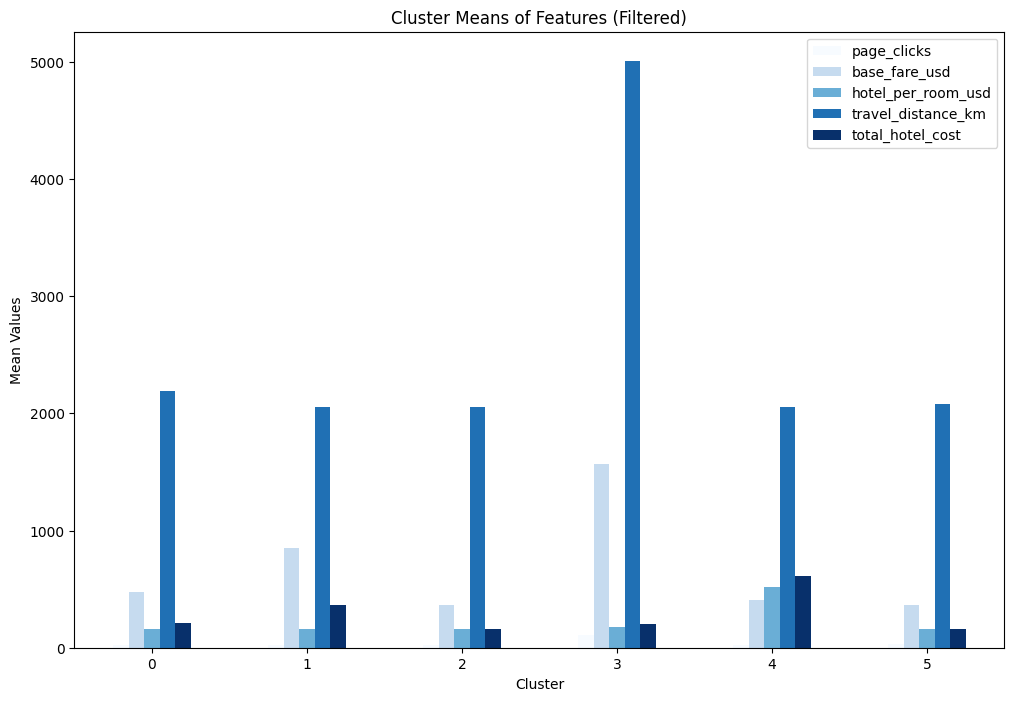

In [ ]:
data_numeric2 = data_numeric.copy().drop(columns=["user_id"])
cluster_means = data_numeric2.groupby("cluster").mean()

# Calculate the variance of each feature across clusters
feature_variances = cluster_means.var()

# Set a threshold for low variance (e.g., features with variance less than a threshold will be removed)
low_variance_threshold = 100
features_to_keep = feature_variances[feature_variances > low_variance_threshold].index

# Filter the cluster means dataframe to keep only features with sufficient variance
cluster_means_filtered = cluster_means[features_to_keep]

# Plotting the bar plot for filtered features
cluster_means_filtered.plot(kind='bar', figsize=(12, 8), cmap='Blues')
plt.title('Cluster Means of Features (Filtered)')
plt.ylabel('Mean Values')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

In [ ]:
data_numeric['cluster'].value_counts()

,count
cluster,
5,4980
2,3905
0,2468
1,1336
4,747
3,542


In [ ]:
cluster_means_filtered.to_csv("cluster_means2.csv", index=False)


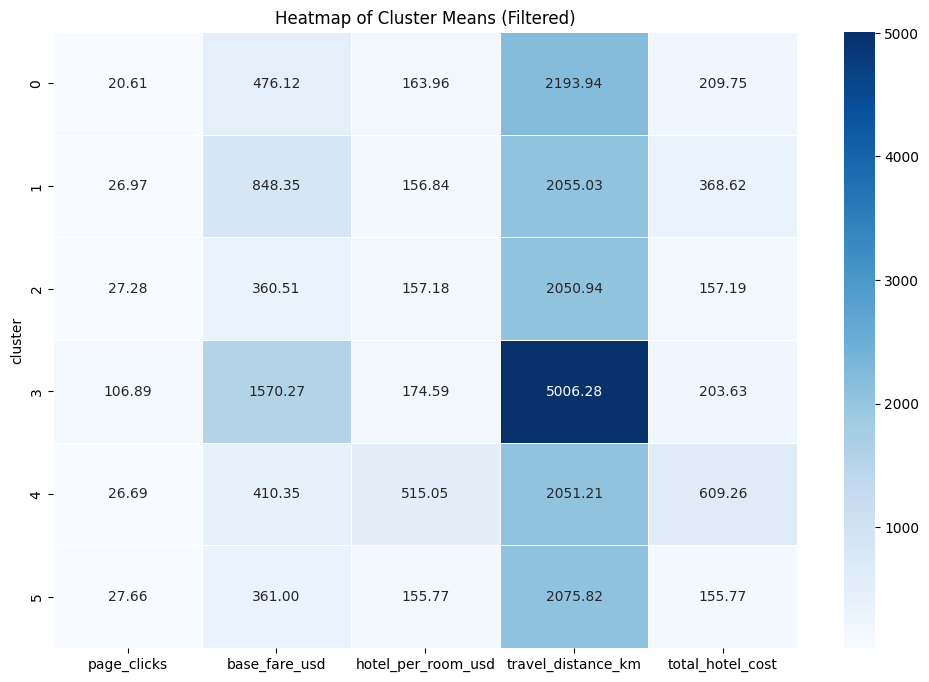

In [ ]:
# Plotting the heatmap for filtered cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_filtered, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Cluster Means (Filtered)')
plt.show()


In [ ]:
'''
Cluster Analysis
1. Cluster 0:
Page Clicks: 20.61
Base Fare: 476.12 USD
Hotel per Room: 163.96 USD
Travel Distance: 2193.94 km
Total Hotel Cost: 209.75 USD
Active Days: 769.30
2. Cluster 1:
Page Clicks: 26.97
Base Fare: 848.35 USD
Hotel per Room: 156.84 USD
Travel Distance: 2055.03 km
Total Hotel Cost: 368.62 USD
Active Days: 770.55
3. Cluster 2:
Page Clicks: 27.28
Base Fare: 360.51 USD
Hotel per Room: 157.18 USD
Travel Distance: 2050.94 km
Total Hotel Cost: 157.19 USD
Active Days: 770.43
4. Cluster 3:
Page Clicks: 106.89
Base Fare: 1570.27 USD
Hotel per Room: 174.59 USD
Travel Distance: 5006.28 km
Total Hotel Cost: 203.63 USD
Active Days: 778.66
5. Cluster 4:
Page Clicks: 26.69
Base Fare: 410.35 USD
Hotel per Room: 515.05 USD
Travel Distance: 2051.21 km
Total Hotel Cost: 609.26 USD
Active Days: 770.55
6. Cluster 5:
Page Clicks: 27.66
Base Fare: 361.00 USD
Hotel per Room: 155.77 USD
Travel Distance: 2075.82 km
Total Hotel Cost: 155.77 USD
Active Days: 769.02

Offer Recommendations
Cluster 0 (Moderate fare, long-distance travel, moderate activity):

Recommended Offer: "10% off next trip"
Reason: This data point shows a balanced level of engagement, fare, and travel distance, suggesting that the traveler is a frequent traveler with moderate spending. A "10% off next trip" offer would help encourage repeat bookings at a reduced cost.
Cluster 1 (High fare, long-distance travel, high engagement):

Recommended Offer: "Discount at special events"
Reason: With high engagement and high fares, this traveler may appreciate exclusive offers related to special events or premium experiences. A discount at special events would cater to their higher budget and frequent engagement.
Cluster 2 (Budget fare, budget accommodation, moderate travel distance):

Recommended Offer: "Free child ticket"
Reason: This data point represents a budget-conscious traveler who spends moderately on base fares and hotel costs. Offering a "Free child ticket" would cater to a family-oriented traveler looking to save on children's fares.
Cluster 3 (Very high fare, extremely long-distance travel, high engagement):

Recommended Offer: "Free meal"
Reason: With a very high fare and long-distance travel, this traveler is likely a frequent traveler, possibly with a high level of cancellations or changes in their booking behavior. Offering a "Free meal" could incentivize booking and provide added value for high-spending travelers.
Cluster 4 (Moderate fare, high hotel cost, moderate travel distance):

Recommended Offer: "Meal voucher"
Reason: This data point represents a traveler who is likely spending a good amount on hotel accommodations. A "Meal voucher" would be an attractive offer for such travelers, especially families, looking for cost-saving opportunities during their stay.
Cluster 5 (Budget fare, budget accommodation, moderate travel distance):

Recommended Offer: "Free child ticket"
Reason: This is similar to Cluster 2 in that it represents a family-oriented traveler with a budget. Offering a "Free child ticket" would appeal to this demographic, helping families travel at a lower cost.

Summary of Recommended Offers:
10% off next trip: Cluster 0 (Moderate fare, frequent traveler)
Discount at special events: Cluster 1 (Higher fare, premium experience seeker)
Free child ticket: Cluster 2 and 5 (Budget-conscious family travelers)
Free meal: Cluster 3 (High fare, frequent traveler)
Meal voucher: Cluster 4 (Family traveler with high hotel cost)
'''

# Recommended Offers per Cluster

<ipython-input-306-9777dc5b88f7>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Offer', y='Frequency', data=offer_counts, palette='Blues')


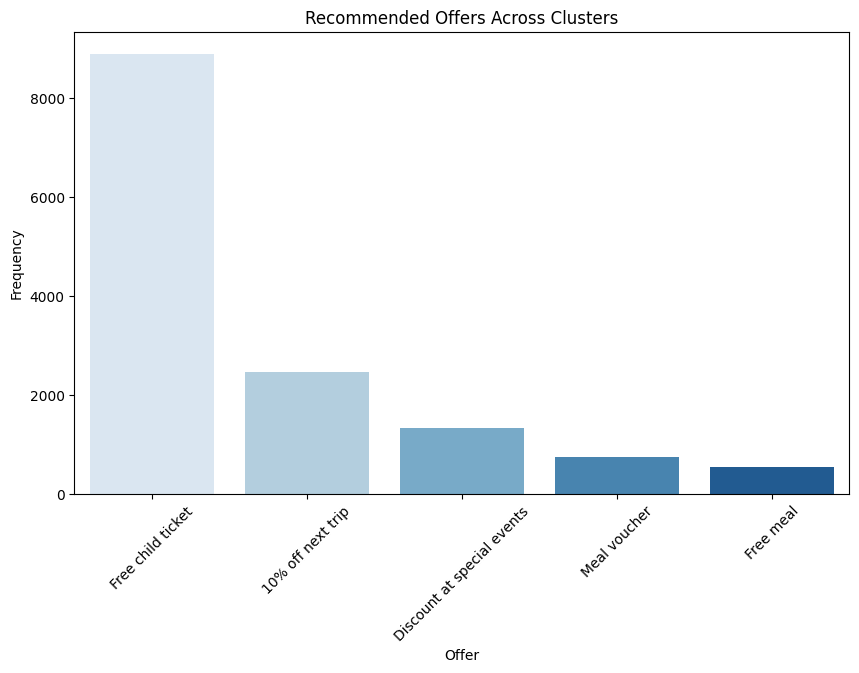

In [ ]:
offer_mapping = {
    0: "10% off next trip",             # Cluster 0: Frequent travelers
    1: "Discount at special events",    # Cluster 1: Frequent engagement, short trips
    2: "Free child ticket",             # Cluster 2: Budget-conscious travelers with families
    3: "Free meal",                     # Cluster 3: Frequent travelers with high cancellations
    4: "Meal voucher",                  # Cluster 4: Family travelers on short trips
    5: "Free child ticket"              # Cluster 5: Married with children
}

data_numeric["recommended_offer"] = data_numeric["cluster"].map(offer_mapping)

# Visualization of Offers by Cluster
offer_counts = data_numeric['recommended_offer'].value_counts().reset_index()
offer_counts.columns = ['Offer', 'Frequency']

plt.figure(figsize=(10, 6))
sns.barplot(x='Offer', y='Frequency', data=offer_counts, palette='Blues')
plt.title("Recommended Offers Across Clusters")
plt.xlabel("Offer")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

# User level Mapping

In [ ]:
# Aggregate user-level features (Example: Average spend, total trips, engagement)
user_features = data_numeric.groupby("user_id").agg({
    "base_fare_usd": "mean",
    "hotel_per_room_usd": "mean",
    "travel_distance_km": "mean",
    "total_hotel_cost": "mean",
    "page_clicks": "mean",
    "active_days": "mean"
}).reset_index()

# Merge with user clusters
user_clusters = data_numeric[["user_id", "cluster"]].drop_duplicates()
user_data = user_features.merge(user_clusters, on="user_id")

user_data["recommended_offer"] = user_data["cluster"].map(offer_mapping)


In [ ]:
user_data[['user_id', 'recommended_offer', 'cluster']].to_csv("user_offers.csv", index=False)

# Predictive Modeling with Random Forest

Accuracy: 0.9892703862660944
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       740
           1       0.98      0.99      0.99       401
           2       1.00      1.00      1.00      1172
           3       0.95      0.95      0.95       163
           4       0.97      0.91      0.94       224
           5       0.99      1.00      0.99      1494

    accuracy                           0.99      4194
   macro avg       0.98      0.97      0.98      4194
weighted avg       0.99      0.99      0.99      4194



<ipython-input-309-8c24d310fb79>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_features.values, y=sorted_features.index, palette='Blues_r')


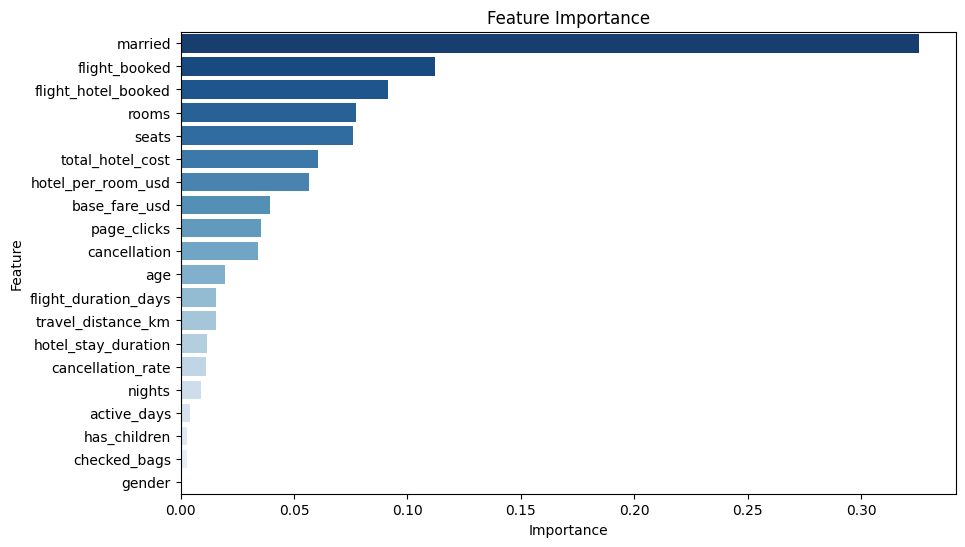

In [ ]:
# Split Data
X = data_numeric[features]
y = data_numeric["cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))
feature_importances = pd.Series(model.feature_importances_, index=features)
sorted_features = feature_importances.sort_values(ascending=False)

# Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_features.values, y=sorted_features.index, palette='Blues_r')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.show()